In [9]:
from math import pi

import numpy as np
from matplotlib import pyplot as plt
from numpy.fft import fftshift

from ppdenoise.ppdenoise import _gaussian_angular_filter, _filter_grids, _grid_angles, _gaussian_angular_filter_3d, \
    _filter_grids_3d, _grid_angles_3d

(5, 10)
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]


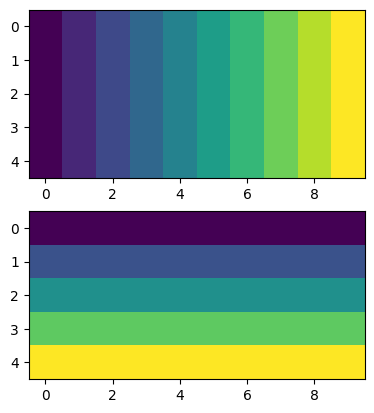

In [36]:
import numpy as np
x, y = np.meshgrid(list(range(10)), list(range(5)))
print(x.shape)

fig, axes = plt.subplots(2)
axes[0].imshow(x)
axes[1].imshow(y)
print(x)
print(y)

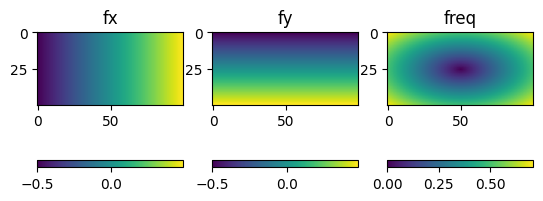

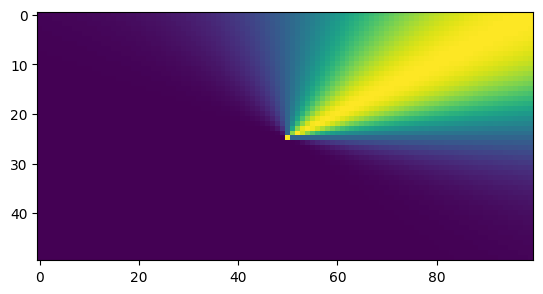

In [28]:
rows, cols = 50, 100
angle_rad = 45 * pi / 180
thetaSigma = pi / 6

freq, fx, fy = _filter_grids(rows, cols)

fig, axes = plt.subplots(1, 3)
cax = axes[0].imshow(fftshift(fx))
axes[0].set_title('fx')
fig.colorbar(cax, orientation='horizontal')
cax = axes[1].imshow(fftshift(fy))
axes[1].set_title('fy')
fig.colorbar(cax, orientation='horizontal')
cax = axes[2].imshow(fftshift(freq))
axes[2].set_title('freq')
fig.colorbar(cax, orientation='horizontal')

sintheta, costheta = _grid_angles(freq, fx, -fy)  # -fy to give anti-clockwise angles (correct)
angle_filter = _gaussian_angular_filter(angle_rad, thetaSigma, sintheta, costheta)

fig, ax = plt.subplots()
ax.imshow(fftshift(angle_filter))

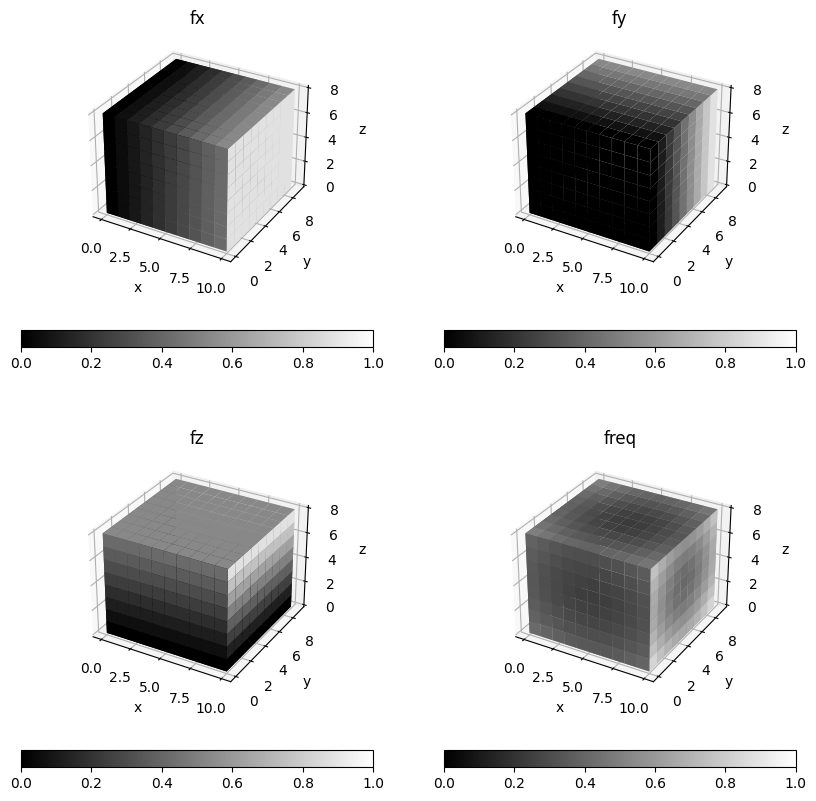

In [26]:
from collections import namedtuple
from math import acos, sqrt, atan
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

plns, rows, cols = 8, 9, 10
freq, fx, fy, fz = _filter_grids_3d(plns, rows, cols)

# Test axes
fig: plt.Figure
axes: np.ndarray[Axes3D]
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)

for ax, vox, title in zip(axes.flatten(), 
                          (fx, fy, fz, freq), 
                          ('fx', 'fy', 'fz', 'freq')):
    vox = fftshift(vox)
    
    size = np.array(vox.shape, dtype=np.intp)
    coord_shape = tuple(size + 1)
    z, y, x = np.indices(coord_shape)  # Grid follows PLANES-ROWS-COLS convention.
    
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    cax = ax.voxels(x, y, z, np.ones_like(vox), facecolors=mpl.colormaps['gray']((vox - vox.min()) / (vox.max() - vox.min())), alpha=1.0)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    fig.colorbar(m, ax=ax, orientation='horizontal')

In [4]:
Ori3D = namedtuple('Ori3D', ['polar', 'azimuth'])
orientations = [Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=0),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=0),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(4 * pi) / 5)]

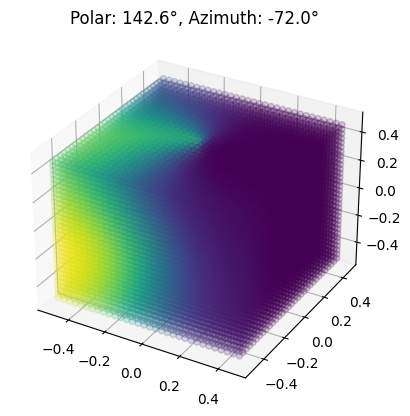

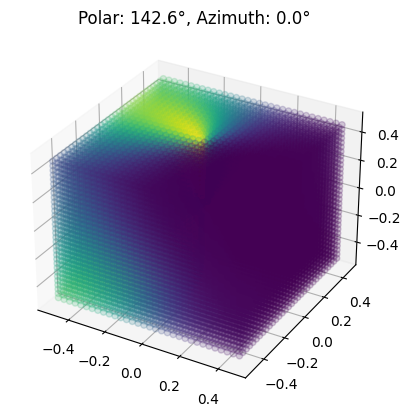

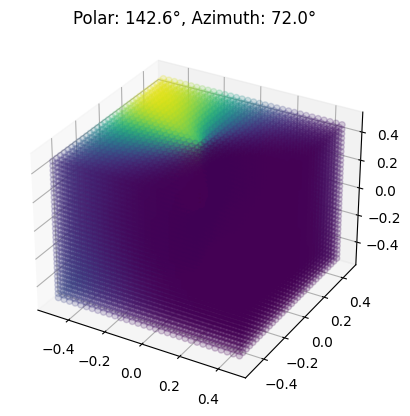

Error in callback <function flush_figures at 0x0000027078F0A980> (for post_execute):



KeyboardInterrupt



In [5]:
from collections import namedtuple
from math import acos, sqrt, atan

import numpy as np
import matplotlib as mpl

plns, rows, cols = 32, 32, 32

Ori3D = namedtuple('Ori3D', ['polar', 'azimuth'])
orientations = [Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=0),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=0),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(2 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(4 * pi) / 5),
                Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(4 * pi) / 5)]


freq, fx, fy, fz = _filter_grids_3d(plns, rows, cols)
sin_polar, cos_polar, sin_azimuth, cos_azimuth = _grid_angles_3d(freq, fx, fy, fz)
theta_sigma = acos(sqrt(5) / 3)  # icosohedron internal angle


from mpl_toolkits.mplot3d import Axes3D



for ori in orientations:
    fig: plt.FuncFormatter
    ax: Axes3D
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth, cos_azimuth)
    ax.scatter3D(fx, fy, fz, c=angle_filter, alpha=0.2)
    ax.set_title(f'Polar: {ori.polar * 180 / pi:.1f}°, Azimuth: {ori.azimuth * 180 / pi:.1f}°')


# rgba =  mpl.colormaps['plasma'](angle_filter)

In [6]:



# fig: plt.Figure
# fig, axes_grid = plt.subplots(10, 10)
# fig.set_size_inches(20, 20)
# 
# for ori, axes in zip(orientations, axes_grid.T):
#     filter_polar = ori.polar
#     filter_azimuth = ori.azimuth
# 
#     print(f'Polar: {filter_polar * 180 / pi:.1f}°, Azimuth: {filter_azimuth * 180 / pi:.1f}°')
#     theta_sigma = acos(sqrt(5) / 3)  # icosohedron internal angle
#     angle_filter = _gaussian_angular_filter_3d(filter_polar, filter_azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth, cos_azimuth)
#     
#     angle_filter = fftshift(angle_filter)
#     for i, ax in enumerate(axes):
#         ax.imshow(angle_filter[5 * i], vmin=0, vmax=1)
#         ax.axis('off')